# USGS earthquake data apply to Australia

### This project apply USGS earthquake data to Australia situation and give some parameters that users can choose time, place and sort by magnitude as they want. When users tap in the coordinate where they are, it will return a distance the nearest earthquake is and show the map. I will explain how to edit the code for using in a wider situation in gernal later.

In [3]:
import requests
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import json
from geopy.distance import geodesic
import datetime

# API request

### First get data from USGS website, write a input box to allow user tap in start and end time and  minmagnitude to sort data they need, then return a simple result of how many earthquakes were in this  selection to test if the URL is accessable. In this example, we set time is from `2022-01-01` to `2023-01-01`, and the minmagnitude is `1`.

In [4]:
# Define the USGS earthquake data API URL
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

# Define the query parameters
params = {
    'format': 'geojson',
    'starttime': '',
    'endtime': '',
    'minmagnitude': '',
    'maxmagnitude': '10',
    'minlatitude': '-44.1',
    'maxlatitude': '-10.4',
    'minlongitude': '112.9',
    'maxlongitude': '154.4'
}

# Get the start and end time from the user
start_time = input('Enter the start time (YYYY-MM-DD): ')
end_time = input('Enter the end time (YYYY-MM-DD): ')

while True:
    try:
        min_mag = float(input('Enter the minimum magnitude: '))
        break  # Exit the loop if the input is valid
    except ValueError:
        print('Invalid input. Please enter a valid floating-point number.')

# Update the query parameters with the user's chosen time range
params['starttime'] = start_time
params['endtime'] = end_time

# Make a request to the USGS API with the updated query parameters
response = requests.get(url, params=params)

# If the request was successful, count the number of earthquakes in Australia
if response.status_code == 200:
    data = response.json()
    count = len(data['features'])
    print(f'There were {count} earthquakes in or next to Australia between {start_time} and {end_time}.')
else:
    print('Error: Could not retrieve earthquake data from USGS API.')


Enter the start time (YYYY-MM-DD):  2022-01-01
Enter the end time (YYYY-MM-DD):  2023-01-01
Enter the minimum magnitude:  1


There were 72 earthquakes in or next to Australia between 2022-01-01 and 2023-01-01.


# Plot the earthquake points in Australia map

### Then we use `matplotlib.pyplot` to plot Australia map and add scatter points on it. Change points' colour by different magnititude.

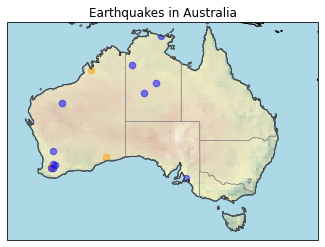

In [5]:
# Set the API endpoint and parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time,
    "endtime": end_time,
    "minmagnitude": min_mag,
    "latitude": "-25.27",
    "longitude": "133.77",
    "maxradiuskm": "5000"
}
    
# Make a GET request to the API endpoint
response = requests.get(url, params=params)

# Check if the response was successful
if response.status_code == 200:
    # Parse the response as GeoJSON data
    geojson_data = response.json()
    # Create a GeoDataFrame of the earthquake data
    earthquakes = gpd.GeoDataFrame.from_features(geojson_data, crs='epsg:4326')
    # Create a map of Australia using the Plate Carree projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([110, 160, -45, -10], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    # Add natural earth features for land and ocean
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='lightblue'))
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Add scatter plot of earthquakes within the Australia map
    for feature in geojson_data["features"]:
        lat = feature["geometry"]["coordinates"][1]
        lon = feature["geometry"]["coordinates"][0]
        properties = feature.get("properties", {})        
        mag = properties.get("mag")
        # The colour changes with magnitude
        if mag is not None and lon >= 110 and lon <= 160 and lat >= -45 and lat <= -10:
            if mag >= 5:
                color = "red"
            elif mag >= 4.5:
                color = "orange"
            elif mag >= 4:
                color = "blue"
            else:
                color = "white"
            ax.scatter(lon, lat, s=mag*10, color=color, alpha=0.5, transform=ccrs.PlateCarree())
    plt.title("Earthquakes in Australia")
    plt.show()
   
else:
    # Print an error message if the response was unsuccessful
    print("Error: Could not retrieve earthquake data.")

# Sort data by state

### Users can tap in the state name they want to get the earthquake points only in this state. Here we use `South Australia(SA)` as an example.

Enter state name (e.g. 'SA'):  SA


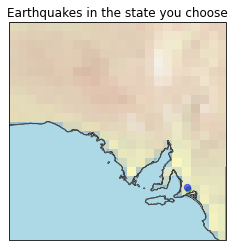

In [6]:
# Set the API endpoint and parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time,
    "endtime": end_time,
    "minmagnitude": min_mag,
    "latitude": "-25.27",
    "longitude": "133.77",
    "maxradiuskm": "5000"
}
# Make a GET request to the API endpoint
response = requests.get(url, params=params)

# Check if the response was successful
if response.status_code == 200:
    # Parse the response as GeoJSON data
    geojson_data = response.json()
    # Create a GeoDataFrame of the earthquake data
    earthquakes = gpd.GeoDataFrame.from_features(geojson_data, crs='epsg:4326')
    #state coordinate
    state_name={
        'SA':[129, 141, -38, -26],
        'ACT':[148.756,149.404,-35.922,-35.125],
        'NSW':[141,154.036,-36.987,-29.177],
        'NT':[129,138,-11.468,-25.996],
        'QLD':[138,153.549,-9.142,-29.177],
        'TAS':[144.568,148.297,-39.108,-43.648],
        'VIC':[140.966,149.974,-33.981,-39.17],
        'WA':[113,129,-14,-35],
    }
    
    #select an area you want to see
    state_code = input("Enter state name (e.g. 'SA'): ")

# Check if state code exists in the dictionary
    if state_code in state_name:

        lon_min, lon_max, lat_min, lat_max = state_name[state_code]
       
    # Create a map of the state we choose using the Plate Carree projection
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.stock_img()
        ax.coastlines()
    # Add natural earth features for land and ocean
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='lightblue'))
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Add scatter plot of earthquakes within the selected state
        for feature in geojson_data["features"]:
            lat = feature["geometry"]["coordinates"][1]
            lon = feature["geometry"]["coordinates"][0]
            properties = feature.get("properties", {})        
            mag = properties.get("mag")
        # Add colour
            if mag is not None and lon >= 110 and lon <= 160 and lat >= -45 and lat <= -10:
                if mag >= 5:
                    color = "red"
                elif mag >= 4.5:
                    color = "orange"
                elif mag >= 4:
                    color = "blue"
                else:
                    color = "green"
                ax.scatter(lon, lat, s=mag*10, color=color, alpha=0.5, transform=ccrs.PlateCarree())
        plt.title("Earthquakes in the state you choose")
        plt.show()
    else:
        print('State code not found. Please enter a valid state code.')
else:
    # Print an error message if the response was unsuccessful
    print("Error: Could not retrieve earthquake data.")
    

# Get earthquakes information

### Then get the 10 earthquakes' information in the highest magnititude in the state user choosed.

In [7]:
# Set the API endpoint and parameters
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time,
    "endtime": end_time,
    "minmagnitude": min_mag,
    "latitude": "-25.27",
    "longitude": "133.77",
    "maxradiuskm": "5000"
}

params['starttime'] = start_time
params['endtime'] = end_time
# Make a GET request to the API endpoint
response = requests.get(url, params=params)

# Check if the response was successful
if response.status_code == 200:
    # Parse the response as GeoJSON data
    geojson_data = response.json()
    # Create an empty list to store earthquake data
    earthquakes = []
    # create a dictionary
    region_dict = {
        'SA': [129, 141, -38, -26],
        'WA': [112, 129, -35, -13],
        'NT': [129, 138, -26, -10],
        'QLD': [138, 154, -29, -10],
        'NSW': [141, 154, -37, -28],
        'VIC': [140, 150, -39, -33],
        'TAS': [144, 148, -44, -39]
}
    # Get user input for region code
    region_code = input("Enter region code (e.g. 'SA'): ")
# Check if region code exists in the dictionary
    if region_code in region_dict:
    # Fill in longitude and latitude values
        lon_min, lon_max, lat_min, lat_max = region_dict[region_code]
        for feature in geojson_data["features"]:
        # Check if the earthquake is located within the boundaries of Australia
            lon, lat = feature["geometry"]["coordinates"][:2]
        # Definate the area we need
            if lon_min <= lon <= lon_max and lat_min <= lat <= lat_max:
            # Extract the earthquake information and append it to the list
                mag = feature["properties"]["mag"]
                time = feature["properties"]["time"]
                place = feature["properties"]["place"]
                earthquakes.append((mag, time, place))
    # Sort the list of earthquakes by magnitude in descending order
        earthquakes.sort(reverse=True)
    # Print the top 10 earthquakes by magnitude
        for i, (mag, time, place) in enumerate(earthquakes[:10]):
        # Convert the timestamp to a human-readable format
            timestamp = time
            timestamp_seconds = timestamp / 1000
            dt = datetime.datetime.utcfromtimestamp(timestamp_seconds)
            formatted_time = dt.strftime("%Y-%m-%d %H:%M:%S")
            print(f"{i+1}. Magnitude {mag} - {place} - {formatted_time}")
    else:
        print('State code not found. Please enter a valid state code.')
else:
    # Print an error message if the response was unsuccessful
    print("Error: Could not retrieve earthquake data.")


Enter region code (e.g. 'SA'):  SA


1. Magnitude 4 - 3 km SW of Mount Barker, Australia - 2022-03-05 20:50:07
2. Magnitude 3 - 3 km ESE of Macclesfield, Australia - 2022-03-29 08:34:51


# Apply in the real world of this program

### Here is an example of calculating the distance of the nearst earthquake from where user is. When tap in the coordinate, it will return a distance of the nearest earthquake, 5 nearest earthquakes' information, and a map. Here is an example that assume we are in ACT (-35,149).

Enter your latitude:  -35
Enter your longitude:  149


The distance to the nearest earthquake is approximately 910.04 kilometers.
Nearest 5 Earthquakes:
1. Distance: 910.04 kilometers, Magnitude: 4.4, Place: 90 km SW of Millicent, Australia,Time:2022-12-27 23:10:54
2. Distance: 923.75 kilometers, Magnitude: 3, Place: 3 km ESE of Macclesfield, Australia,Time:2022-03-29 08:34:51
3. Distance: 926.46 kilometers, Magnitude: 4, Place: 3 km SW of Mount Barker, Australia,Time:2022-03-05 20:50:07
4. Distance: 1347.24 kilometers, Magnitude: 4.5, Place: off the south coast of Australia,Time:2022-06-26 16:16:46
5. Distance: 2180.72 kilometers, Magnitude: 4.6, Place: None,Time:2022-12-11 14:34:48


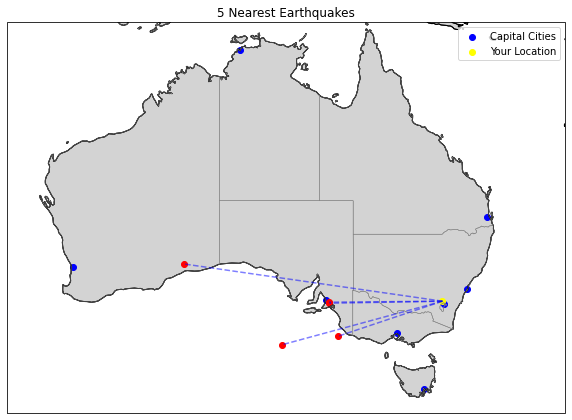

In [8]:
# Get user input for latitude and longitude
latitude = None

while latitude is None:
    try:
        latitude = float(input("Enter your latitude: "))
        if not -45 <= latitude <= -10:
            print("Latitude must be in the [-45; -10] range.")
            latitude = None
    except ValueError:
        print("Invalid input. Please enter a valid latitude.")

longitude = None

while longitude is None:
    try:
        longitude = float(input("Enter your longitude: "))
        if not 110 <= longitude <= 160:
            print("Longitude must be in the [110; 160] range.")
            longitude = None
    except ValueError:
        print("Invalid input. Please enter a valid longitude.")

# Build the URL for the USGS API query
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
params = {
    "format": "geojson",
    "starttime": start_time,
    "endtime": end_time,
    "minmagnitude": min_mag,
    'maxmagnitude': '10',
    'minlatitude': -43.634597,
    'maxlatitude': -9.083334,
    'minlongitude': 112.909308,
    'maxlongitude': 153.63875,
}

# Send a GET request to the USGS API
response = requests.get(url, params=params)
data = response.json()

# Calculate the distance to the nearest earthquake
nearest_distance = float('inf')
nearest_earthquake = None

for feature in data['features']:
    quake_longitude, quake_latitude = feature['geometry']['coordinates'][:2]
    distance = geodesic((latitude, longitude), (quake_latitude, quake_longitude)).kilometers
    nearest_distance = min(nearest_distance, distance)

# Print the distance to the nearest earthquake
print(f"The distance to the nearest earthquake is approximately {nearest_distance:.2f} kilometers.")

# Calculate the distance to each earthquake and store its information
earthquakes = []
for feature in data['features']:
    quake_longitude, quake_latitude = feature['geometry']['coordinates'][:2]
    distance = geodesic((latitude, longitude), (quake_latitude, quake_longitude)).kilometers
    earthquakes.append((distance, feature))

# Sort the list of earthquakes by distance in ascending order
earthquakes.sort()

# Print the nearest 5 earthquakes
print("Nearest 5 Earthquakes:")
for i, (distance,feature) in enumerate(earthquakes[:5]):
        magnitude = feature['properties']['mag']
        place = feature['properties']['place']
        time = feature["properties"]["time"]
        # Convert the timestamp to a human-readable format
        timestamp = time
        timestamp_seconds = timestamp / 1000
        dt = datetime.datetime.utcfromtimestamp(timestamp_seconds)
        formatted_time = dt.strftime("%Y-%m-%d %H:%M:%S")
        print(f"{i+1}. Distance: {distance:.2f} kilometers, Magnitude: {magnitude}, Place: {place},Time:{formatted_time}")

    
# Create a list to store earthquake distances and locations
earthquakes = []

# Calculate the distances and store the earthquake locations within Australia
for feature in data['features']:
    quake_longitude, quake_latitude = feature['geometry']['coordinates'][:2]
    if 110 <= quake_longitude <= 160 and -45 <= quake_latitude <= -10:
        distance = geodesic((latitude, longitude), (quake_latitude, quake_longitude)).kilometers
        earthquakes.append((distance, quake_latitude, quake_longitude))

# Sort the earthquakes by distance
earthquakes.sort()

# Keep only the 10 nearest earthquakes
nearest_earthquakes = earthquakes[:5]

# Create a plot with an Australia basemap
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add the Australia basemap
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')

capital_cities = {
    'Canberra': (-35.2809, 149.1300),
    'Sydney': (-33.8688, 151.2093),
    'Brisbane': (-27.4698, 153.0251),
    'Perth': (-31.9505, 115.8605),
    'Adelaide': (-34.9285, 138.6007),
    'Melbourne': (-37.8136, 144.9631),
    'Hobart': (-42.8821, 147.3272),
    'Darwin': (-12.4634, 130.8456)
}

sc = ax.scatter(
    [lon for lat, lon in capital_cities.values()],
    [lat for lat, lon in capital_cities.values()],
    color='blue',
    label='Capital Cities'
)

    # Plot the nearest earthquake locations
for _, quake_lat, quake_lon in nearest_earthquakes:
    plt.scatter(quake_lon, quake_lat, color='red', transform=ccrs.PlateCarree())
    
# Add a marker for the user's location
plt.scatter(longitude, latitude, color='yellow', label='Your Location', transform=ccrs.PlateCarree())

# Connect the nearest earthquake locations to the user's location with lines
for _, quake_lat, quake_lon in nearest_earthquakes:
    plt.plot([longitude, quake_lon], [latitude, quake_lat], color='blue', linestyle='--', alpha=0.5,
             transform=ccrs.PlateCarree())

# Set the plot extent to cover Australia
ax.set_extent([110, 160, -45, -10], crs=ccrs.PlateCarree())
# Set the plot title
plt.title('5 Nearest Earthquakes')

ax.legend(handles=[sc])
ax.legend()

# Display the plot
plt.show()


### For some earthquakes is outside Australia mainland and when these earthquakes are large enough, they can affect people as well even the epicenters are in the ocean. So I did't exclude the earthquakes off  the coast.

# The usage in a gernal situation

### If user want to modify the program to plot earthquake data for other countries, it would need to make  changes in two main areas: the map centering and the API request.

### API Request:
### Adjust the API request URL to specify the desired country's earthquake data. Update the starttime, endtime, and minmagnitude parameters in the URL to set the appropriate time  range and magnitude threshold. Replace the URL in the requests.get function with the updated API request URL. Make sure to include  the necessary parameters and format. For example: if we want to change this map to Japan, which coordinate is [35.68, 139.96], we should modify this code as:

In [9]:
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime":'2022-06-01',
    "endtime":'2023-01-01',
    "minmagnitude":'1',
    # put your countary coordinate here:
    "latitude": "35.68",
    "longitude": "139.96",
    "maxradiuskm": "5000"
}

### Map Centering:
### Identify the latitude and longitude coordinates that correspond to the center of the country they're  interested in. Replace the values [110, 160, -45, -10] in the mapping code. For example, if you want to center the  map on Japan, you might use [122, 153, 20, 45] as the coordinates and change the it at here: 
`ax.set_extent([122, 153, 20, 45], crs=ccrs.PlateCarree())` 
### and here: 
`if mag is not None and lon >= 112 and lon <= 153 and lat >= 20 and lat <= 45:`

### Then we combine upon and map it:

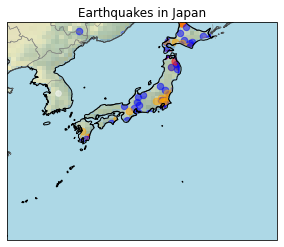

In [10]:
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime":'2022-06-01',
    "endtime":'2023-01-01',
    "minmagnitude":'1',
    # put your countary coordinate here:
    "latitude": "35.68",
    "longitude": "139.96",
    "maxradiuskm": "5000"
}
# Make a GET request to the API endpoint
response = requests.get(url, params=params)

# Check if the response was successful
if response.status_code == 200:
    # Parse the response as GeoJSON data
    geojson_data = response.json()
    # Create a GeoDataFrame of the earthquake data
    earthquakes = gpd.GeoDataFrame.from_features(geojson_data, crs='epsg:4326')
    # Create a map of Japan using the Plate Carree projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([122, 153, 20, 45], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    # Add natural earth features for land and ocean
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='lightblue'))
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Add scatter plot of earthquakes within the Japan map
    for feature in geojson_data["features"]:
        lat = feature["geometry"]["coordinates"][1]
        lon = feature["geometry"]["coordinates"][0]
        properties = feature.get("properties", {})        
        mag = properties.get("mag")
        # The colour changes with magnitude
        if mag is not None and lon >= 122 and lon <= 153 and lat >= 20 and lat <= 45:
            if mag >= 5:
                color = "red"
            elif mag >= 4.5:
                color = "orange"
            elif mag >= 4:
                color = "blue"
            else:
                color = "white"
            ax.scatter(lon, lat, s=mag*10, color=color, alpha=0.5, transform=ccrs.PlateCarree())
    plt.title("Earthquakes in Japan")
    plt.show()
   
else:
    # Print an error message if the response was unsuccessful
    print("Error: Could not retrieve earthquake data.")
# Attention: not all the countries can use this code, like Mexico.

# Conclusion

### There are still many questions in this program, especially clear in the last example of Japan, like the area is just a square, which is suitable for large and regular countries such as Australia or Canada, but this is not suitable for some small or complex countries. In all, it achieved showing earthquake points in different megnititude and reach their information directly in a simple area sort program, and user can get the updated information of the nearest earthquake by themselves.